# NOTE

The Trackman data is confidential, so the data used in this script is only to show the main methods used.

The data is simulated using the create_sim_data.ipynb script.

For this script only the ResNet architecture is used, but all models have been trained similarly.

The results are not representative of the actual results using the real dataset.

# Loading the data

In [3]:
from pathlib import Path

from numpy import log10
import torch
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from custom_transforms import LoadSpectrogram, NormalizeSpectrogram, ToTensor, InterpolateSpectrogram
from data_management import make_dataset_name
from models import weights_init_uniform_rule, SpectrVelCNNRegr, ResNet

# from modular_train_test import train_one_epoch

MODEL = ResNet
LEARNING_RATE = 10**(-3.46)
WEIGHT_DECAY = 10**(-5.39)
# EPOCHS = 300 # Normally set to 300 for the real data
BATCH_SIZE = 16
NUM_WORKERS = 0
OPTIMIZER = torch.optim.Adam
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Paths
DATA_ROOT = Path("../data")
STMF_FILENAME = "stmf_data_3.csv"
train_dir = DATA_ROOT / "train"
validation_dir = DATA_ROOT / "validation"

# Transforms
TRAIN_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=train_dir),
    ToTensor(),
])

VALIDATION_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=validation_dir),
    ToTensor(),
])

train_dataset = MODEL.dataset(data_dir= DATA_ROOT / "train",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TRAIN_TRANSFORM)

validation_dataset = MODEL.dataset(data_dir= DATA_ROOT / "validation",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=VALIDATION_TRANSFORM)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Test the dataloaders
for batch in train_data_loader:
    print(batch["spectrogram"].shape)
    print(batch["target"].shape)
    break


torch.Size([16, 6, 74, 918])
torch.Size([16])


# Set up model

In [10]:
model = MODEL().to(DEVICE)
model.apply(weights_init_uniform_rule)

optimizer = OPTIMIZER(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

/home/tjasmussen/miniconda3/envs/jupyt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tjasmussen/miniconda3/envs/jupyt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_one_epoch(loss_fn, model, train_data_loader):
    running_loss = 0.
    last_loss = 0.
    total_loss = 0.

    for i, data in enumerate(train_data_loader):

        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE)
        
        optimizer.zero_grad()

        outputs = model(spectrogram)

        loss = loss_fn(outputs.squeeze(), target)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()
        if i % train_data_loader.batch_size == train_data_loader.batch_size - 1:
            last_loss = running_loss / train_data_loader.batch_size # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return total_loss / (i+1)

# Perform training

In [11]:
out_dict = {
        "loss": [],
        "rmse": [],
        "log_rmse": [],
        "test_loss": [],
        "test_rmse": [],
        "log_test_rmse": [],
    }
print(out_dict['loss'])
out_dict['loss'].append(2)
EPOCHS = 50
epoch_number = 0
best_vloss = 10000
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)

    # Do a pass over the training data and get the average training MSE loss
    avg_loss = train_one_epoch(MODEL.loss_fn, model, train_data_loader)
    
    rmse = avg_loss**(1/2)

    log_rmse = log10(rmse)

    running_test_loss = 0.

    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_data_loader):
      
            spectrogram, target = vdata["spectrogram"].to(DEVICE), vdata["target"].to(DEVICE)  # Use only the 5th channel, keep channel dimension
            
            test_outputs = model(spectrogram)

            test_loss = MODEL.loss_fn(test_outputs.squeeze(), target)

            running_test_loss += test_loss

    avg_test_loss = running_test_loss / (i + 1)

    test_rmse = avg_test_loss**(1/2)

    log_test_rmse = torch.log10(test_rmse)

    print('LOSS train {} ; LOSS validation {}'.format(avg_loss, avg_test_loss))
    
    out_dict['loss'].append(avg_loss)
    out_dict['rmse'].append(rmse)
    out_dict['log_rmse'].append(log_rmse)
    out_dict['test_loss'].append(test_loss.item())
    out_dict['test_rmse'].append(test_rmse.item())
    out_dict['log_test_rmse'].append(log_test_rmse.item())
    # Track best performance, and save the model's state
    if avg_test_loss < best_vloss:
        best_vloss = avg_test_loss
        # torch.save(model.state_dict(), model_path)

    epoch_number += 1

[]
EPOCH 1:
  batch 16 loss: 549.9058513641357
LOSS train 478.1722693192331 ; LOSS validation 203.56939697265625
EPOCH 2:
  batch 16 loss: 13.878133863210678
LOSS train 12.090626453098498 ; LOSS validation 52.08123016357422
EPOCH 3:
  batch 16 loss: 2.114000082015991
LOSS train 2.0878064946124426 ; LOSS validation 3.064389705657959
EPOCH 4:
  batch 16 loss: 1.2438553292304277
LOSS train 1.259663821835267 ; LOSS validation 0.18007704615592957
EPOCH 5:
  batch 16 loss: 1.1812900193035603
LOSS train 1.1832242953149896 ; LOSS validation 0.3921659290790558
EPOCH 6:
  batch 16 loss: 1.0286955386400223
LOSS train 1.1130949039208262 ; LOSS validation 0.6663756370544434
EPOCH 7:
  batch 16 loss: 0.8236893601715565
LOSS train 0.7432301067992261 ; LOSS validation 0.11334902793169022
EPOCH 8:
  batch 16 loss: 0.9740135557949543
LOSS train 1.101811408996582 ; LOSS validation 0.1638624370098114
EPOCH 9:
  batch 16 loss: 1.303043108433485
LOSS train 1.2452991667546724 ; LOSS validation 0.220782250165

# Plot learning curves

Text(0, 0.5, 'Accuracy')

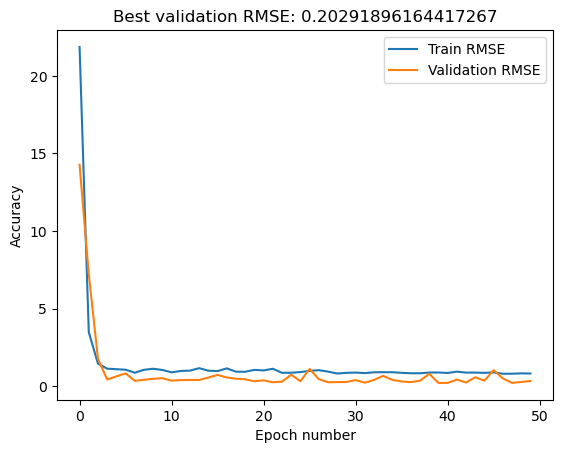

In [16]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(out_dict['rmse'], label='Train rmse')
plt.plot(out_dict['test_rmse'], label='Validation rmse')
plt.title(f'Best validation RMSE: {np.min(out_dict['test_rmse'])}')
plt.legend(('Train RMSE','Validation RMSE'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')

# Testing the models and computing the residuals

In [19]:
test_dir = DATA_ROOT / "test"

TEST_TRANSFORM = Compose([
    LoadSpectrogram(root_dir=test_dir),
    ToTensor()
])

test_dataset = MODEL.dataset(data_dir= DATA_ROOT / "test",
                        stmf_data_path = DATA_ROOT / STMF_FILENAME,
                        transform=TEST_TRANSFORM)

test_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

In [20]:
total_residuals = []
running_loss = 0.0
total_samples = 0

model.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(test_data_loader):
        spectrogram, target = data["spectrogram"].to(DEVICE), data["target"].to(DEVICE)

        outputs = model(spectrogram)

        residuals = outputs - target

        total_residuals.append(residuals)

        loss_fn = MODEL.loss_fn 
        loss = loss_fn(outputs.squeeze(), target)

        running_loss += loss.item() * spectrogram.size(0)
        total_samples += spectrogram.size(0)

        rmse = torch.sqrt(loss)

# Calculate average loss over the entire validation set
avg_loss = running_loss / total_samples
avg_rmse = avg_loss ** 0.5  # Calculate RMSE from MSE loss

/home/tjasmussen/Documents/deep_learning/dl_p4_g41/scripts/loss.py:6: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch_mse_loss(output, target)


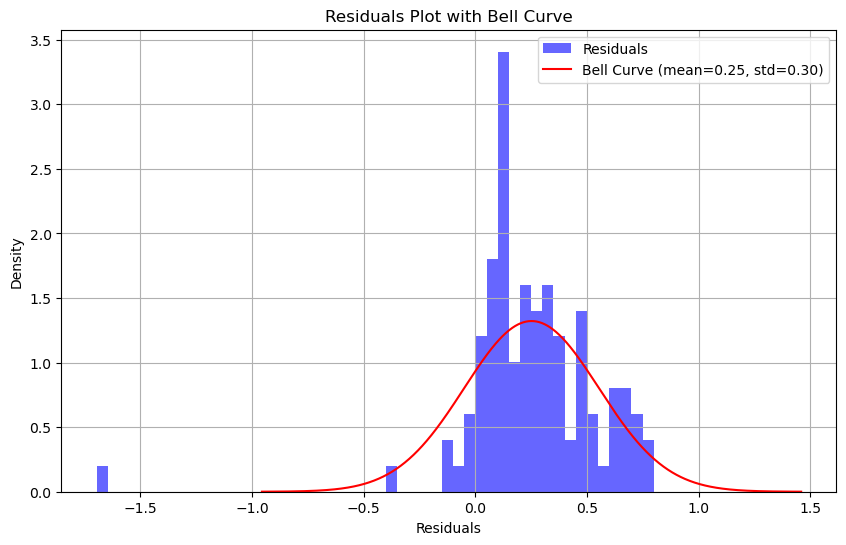

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

total_residuals = torch.cat(total_residuals).cpu().numpy()

mean_residuals = np.mean(total_residuals)
std_residuals = np.std(total_residuals)

x = np.linspace(mean_residuals - 4 * std_residuals, mean_residuals + 4 * std_residuals, 1000)
bell_curve = norm.pdf(x, mean_residuals, std_residuals)

plt.figure(figsize=(10, 6))
plt.hist(total_residuals, bins=50, density=True, alpha=0.6, color='blue', label='Residuals')
plt.plot(x, bell_curve, 'r-', label=f'Bell Curve (mean={mean_residuals:.2f}, std={std_residuals:.2f})')

# Add labels, title, and legend
plt.title('Residuals Plot with Bell Curve')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Making saliency maps for one test image

In [22]:
images = next(iter(test_data_loader))
input_tensor, labels = images["spectrogram"].to(DEVICE), images["target"].to(DEVICE)

original_image_first_channel = input_tensor[0, 0, :, :].detach().cpu().numpy()
input_tensor = input_tensor[0,:,:,:]
labels = labels[0]

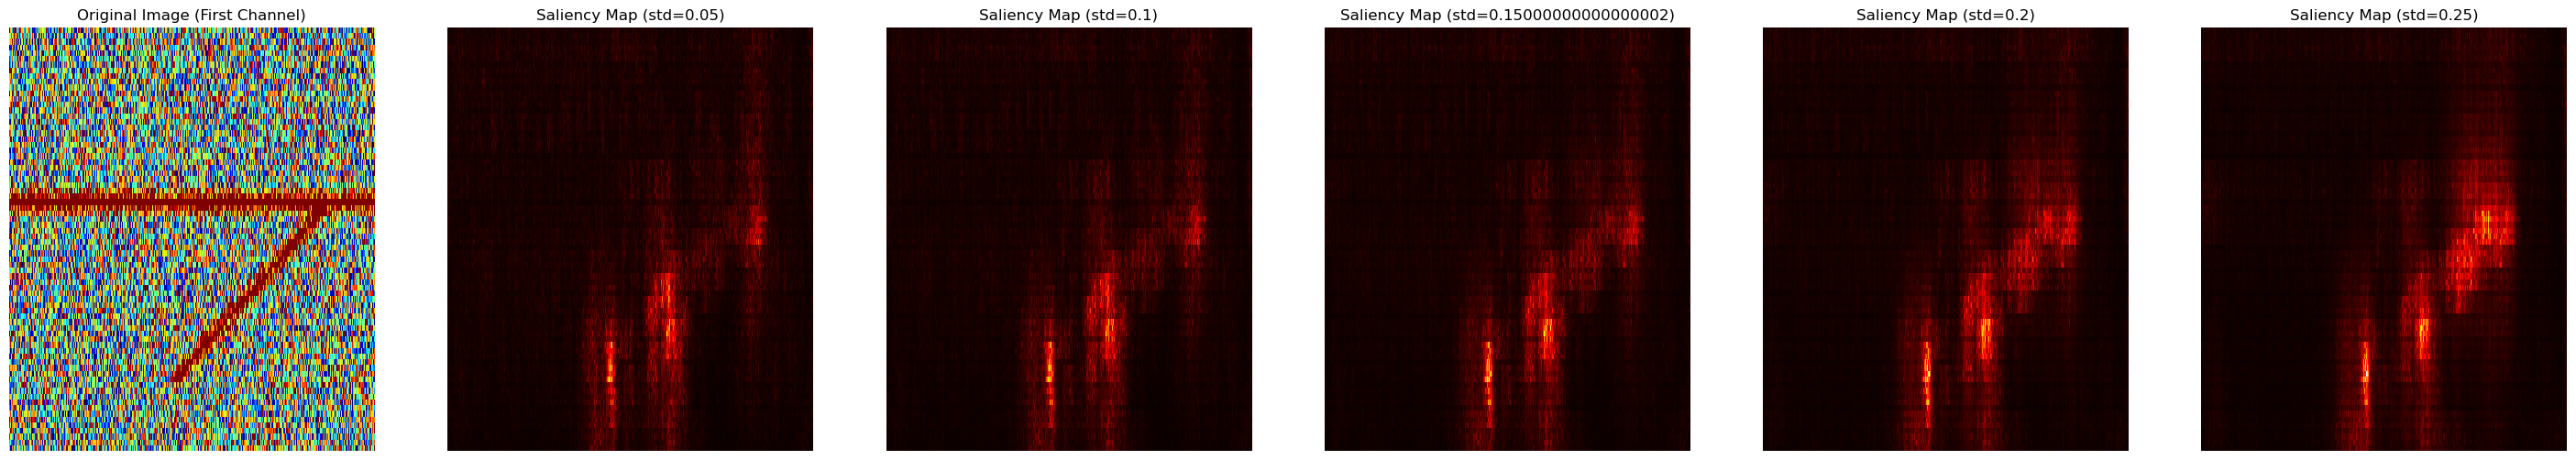

In [23]:
# from saliency import smooth_grad
import importlib
import saliency
importlib.reload(saliency)
from saliency import smooth_grad

TS_CROPTWIDTH = (-150, 200)
VR_CROPTWIDTH = (-60, 15)

fig, axs = plt.subplots(1, 6, figsize=(36, 6))
axs[0].imshow(original_image_first_channel, aspect="auto", 
    extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
            VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
    origin="upper",
    interpolation='nearest',
    cmap="jet")
axs[0].set_title("Original Image (First Channel)")
axs[0].axis('off')

print
for i in range(1, 6):
    std = 0.05*i
    saliency_map = smooth_grad(model, input_tensor, labels, num_samples=50, noise_level=std, device=DEVICE)

    saliency_map_reshaped = saliency_map.squeeze()

    axs[i].imshow(saliency_map_reshaped, origin='upper', aspect="auto", 
        extent=[TS_CROPTWIDTH[0]/1000,TS_CROPTWIDTH[1]/1000,
                VR_CROPTWIDTH[0],VR_CROPTWIDTH[1]],
        interpolation='nearest',
        cmap='hot')
    axs[i].set_title(f"Saliency Map (std={std})")
    axs[i].axis('off')

# plt.tight_layout()
# plt.savefig(f"plots/saliency_map_comparison_}.png", dpi=300)
plt.show()